In [93]:
import matplotlib.pylab as plt 
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge

# 1. Cost functions

Lets focus on linear regression of the form 

$\mathbf{y} \approx f(\mathbf{X}) = \mathbf{X}\mathbf{w_1} + \mathbf{w_0}.$


#### 1.1 What are the rows of $\mathbf{X}$?

Each row of X represents a single data sample/observation. If we have N samples, X has N rows

#### 1.2 What are the columns of $\mathbf{X}$?

Each column of X represents a feature/variable. If we have D features, X has D columns.

Often, we write the equation above as

$\mathbf{y} \approx \mathbf{\tilde{X}}\mathbf{w}$

#### 1.3 How does $\mathbf{\tilde{X}}$ look like in this case (i.e., how does the shape of the matrix change compared to $\mathbf{X}$)?

$\tilde{X}$ is $X$ with an additional column of ones prepended (or appended) to it to account for the bias term $w_{0}$. If $X$ is (N x D), then $\tilde{X}$ is (N x D+1).

For machine learning, we need a cost function. Two common choices are the mean-squared error (MSE, $\mathcal{L}_2$), and the mean-absolute error (MAE, $\mathcal{L}_1$)

\begin{align}
    \mathcal{L}_2 &=& \frac{1}{N} \sum_{i=1}^N \left(y_i - f(x_i) \right)^2 \\
    \mathcal{L}_1 &=& \frac{1}{N} \sum_{i=1}^N \left|y_i - f(x_i) \right| 
\end{align}

#### 1.4 In the Jupyter notebook, write a Python function that computes these two cost functions given an error term $\boldsymbol{\epsilon} = \mathbf{y} - \mathbf{\tilde{X}}\mathbf{w}$

In [94]:
def mean_squared_error(error_vector):
    mean_squared_error = np.mean(error_vector ** 2)
    return mean_squared_error

In [95]:
def mean_absolute_error(error_vector):
    mean_absolute_error = np.mean(np.abs(error_vector))
    return mean_absolute_error

In [96]:
print("Testing MSE with [1,4,7]:", mean_squared_error(np.array([1,4,7])))
print("Testing MAE with [1,4,7]:", mean_absolute_error(np.array([1,4,7])))

Testing MSE with [1,4,7]: 22.0
Testing MAE with [1,4,7]: 4.0


Your code should run as follows

```python
mean_squared_error(np.array([0,0,0]))
> returns 0
```

```python
mean_squared_error(np.array([1,1,1]))
> returns 1
```

#### 1.5 What is the shape of these cost functions as a function of the error

In [97]:
x_axis = np.linspace(-15,15,150) # change as you wish for your plot
y_mae = [mean_absolute_error(x) for x in x_axis]
y_mse = [mean_squared_error(x) for x in x_axis]

Text(0, 0.5, 'cost function')

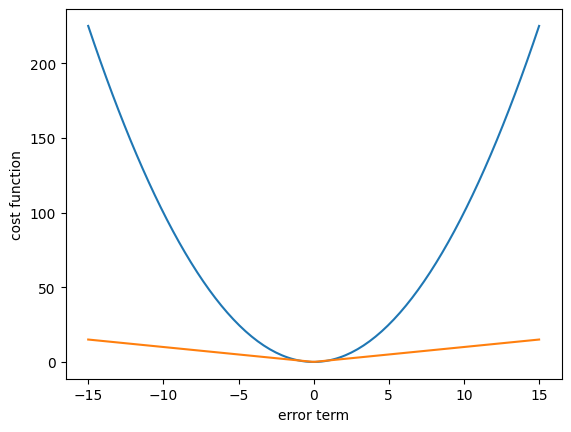

In [98]:
plt.plot(x_axis, y_mse, label='MSE')
plt.plot(x_axis, y_mae, label='MAE')
plt.xlabel('error term')
plt.ylabel('cost function')

#### 1.6  Are both loss functions differentiable for all $\boldsymbol{\epsilon}$? What implications does this have for gradient based optimization like gradient descent?

MSE is differentiable everywhere. MAE is NOT differentiable at ε=0 ( it has a sharp corner ). For gradient descent, this means:

- MSE: Always has a well-defined gradient, smooth optimization
- MAE: Gradient undefined at zero, can cause issues with gradient-based methods, requires subgradient methods or smoothing

#### 1.7 Which loss function is more sensitive to outliers and why?

MSE is more sensitive to outliers because it squares the errors. Large errors (outliers) get amplified quadratically. For example:

- Error of 10: MSE contribution = 100, MAE contribution = 10
- The squared term in MSE penalizes large errors much more heavily than MAE

# 2. Regularization

Assume that the columns of $\mathbf{X}$ are linearly independent.
As a refresher of linear algebra, recall when the linear system $\mathbf{X}\mathbf{w} = \mathbf{y}$ has

#### 2.1 One unique solution

The system $Xw = y$ has a unique solution when:

- $rank(X)$ = $rank(X|y)$ = number of unknowns (columns of X)

This occurs when X is full column rank (typically when N ≥ D and columns are independent)

#### 2.2 No solution

The system has no solution when:

- $rank(X)$ < $rank(X|y)$

This means y is not in the column space of X (inconsistent system)

#### 2.3 An infinite number of solutions

The system has infinite solutions when:

- $rank(X)$ = $rank(X|y)$ < number of unknowns

This occurs when X doesn't have full column rank (columns are linearly dependent)

#### 2.4 Give a geometrical interpretation of the matrix Rank (10 bonus point if you use the Manim package)

The rank of a matrix represents the dimension of the vector space spanned by its columns (or rows). Geometrically:

- rank=1: all columns lie on a line through origin
- rank=2: all columns lie in a plane through origin
- rank=D: columns span a D-dimensional space

The rank tells us how many "truly independent" directions the matrix captures. (See video Rank2D.mp4)

#### 2.5 In general, why can't we solve the linear equation using $\mathbf{y} = \tilde{\mathbf{X}}^{-1}\textbf{w}$? (1 point)

We cannot use this formula because:

1. $\tilde{X}$ is typically not square (N samples × D+1 features), so it has no inverse
2. Even if square, $\tilde{X}$ might be singular (not invertible) if columns are dependent
3. The equation should be $w$ = $\tilde{X}^{-1}y$ anyway (solving for $w$, not $y$)

#### 2.6 Differentiate above formula step by step and show what will we have?

Starting with $(y - X̃w){^T}(y - X̃w)$, expand:

 = $y^{T}$ $y$ - $y^{T}$ $\tilde{X}w$ - $w^{T}$ $\tilde{X}^{T}$ $y$ + $w^{T}$ $\tilde{X}^{T}$ $\tilde{X}w$

 = $y^{T}$ $y$ - $2w^{T}$ $\tilde{X}^{T}$ $y$ + $w^{T}$ $\tilde{X}^{T}$ $\tilde{X}w$ (since $w^{T}$ $\tilde{X}^{T}$ $y$ is scalar = $y^{T}$ $\tilde{X}w$)

Taking derivative with respect to w:
$\frac{d}{dw}$ = $-2\tilde{X}^{T}$ $y$ + $2\tilde{X}^{T}$ $\tilde{X}w$

#### 2.7 if we want $\| y - \tilde{X} w \|_2^2$ to be minimum, what should the derivative be equal to?

For minimum, the derivative must equal zero:

$-2X̃{^T}$ $y$ + $2X̃{^T}$ $X̃w$ = 0

This gives the normal equation: $X̃{^T}$ $X̃w$ = $X̃{^T}$ $y$

#### 2.8 What is the Hat matrix and what does its diagonal values correspond to?

- The Hat matrix is H = $X̃(X̃{^T} X̃){^{-1}}X̃{^T}$, it projects y onto the column space of $X̃$: $ŷ$ = $Hy$
- The diagonal values $H_{ii}$ (leverage) represent how much influence the i-th observation has on its own predicted value. High leverage points have large $H_{ii}$.

#### 2.9 What is Willson’s plot and how does it help in outlier detection?

Wilson's plot (residuals vs leverage plot) plots residuals against leverage values (diagonal of Hat matrix). It helps detect:
- High leverage points (far from mean of predictors)
- Outliers (large residuals)
- Influential points (high leverage AND large residual)

Points in upper-right/lower-right are most concerning for outlier detection.

#### 2.10 What happens if some columns are linearly dependent? What is the connection to feature selection?

If columns are linearly dependent, then $X̃{^T}$ $X̃$ is singular (non-invertible).

$rank(X̃)$ < number of columns, so the system has infinite solutions.

Connection to feature selection: Dependent features provide redundant information.
Feature selection removes redundant/dependent features, ensuring X has full column rank.

#### 2.11 What will be the new cost function after adding the regularization term?

The regularized cost function is:
$L(w)$ = $(y - X̃w){^T}(y - X̃w)$ + $λ||w||²₂$ = $||y - X̃w||²₂$ + $λw{^T}w$

#### 2.12 What will be the new 𝑤 when we differentiate the new cost function and set it to zero.

Differentiating the regularized cost and setting to zero:

$-2X̃{^T}$ y + $2X̃{^T}$ $X̃w$ + $2λw$ = 0

$X̃{^T}$ $X̃w$ + $λw$ = $X̃{^T}$ y

$(X̃{^T} X̃ + λI)w$ = $X̃{^T}$ y

Therefore: $w$ = $(X̃{^T} X̃ + λI){^{-1}}X̃{^T}$ y

#### 2.13 Prove that the part of Hat matrix where we want to take the inverse from is always reversible after we introduce the regularization term.

We need to show $(X̃{^T} X̃ + λI)$ is always invertible for λ > 0.

##### Proof:
$X̃{^T}$ $X̃$ is positive semi-definite (all eigenvalues ≥ 0). Adding λI adds λ to all eigenvalues, making them all > 0 when λ > 0. A matrix with all positive eigenvalues is positive definite, hence invertible.

#### 2.14  What is the shape of the parabola as a function of $a$?

In [ ]:
def parabola(x, a = 1): 
    return a * x ** 2

In [ ]:
x_axis_parabola = np.linspace(-10, 10, 100)

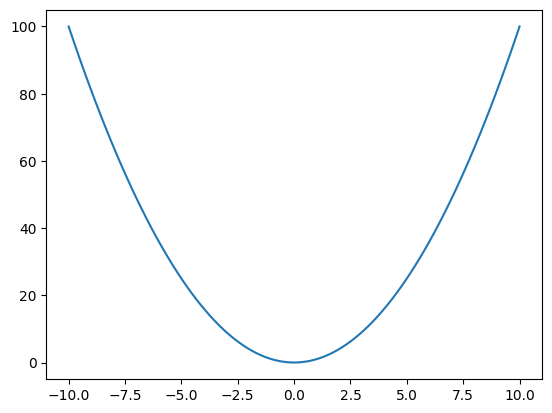

In [ ]:
plt.plot(x_axis_parabola, parabola(x_axis_parabola))

As 'a' increases, the parabola becomes narrower/steeper.

- As 'a' decreases toward 0, the parabola becomes wider/flatter.
- This relates to regularization: smaller weights (smaller 'a') create smoother

#### 2.15 Plot the approximation to the function for different order polynomials ($N \in \{1, 2, 16\}$) and with different regularization strength ($\lambda \in \{0, 10^{-3}, 10^{-2}, 1\}$). What do you observe 

In [ ]:
def true_function(X):
    return np.cos(1.5 * np.pi * X)

In [ ]:
X_test = np.linspace(0, 1, 100) # some grid for us on the x axis

In [ ]:
n_samples = 10 # the number of points we will sample from true_function
degrees = [1, 2, 16] # the polynomial degrees we will test

X = np.sort(np.random.rand(n_samples))
y = true_function(X) + np.random.randn(n_samples) * 0.1 # add some scaled random noise

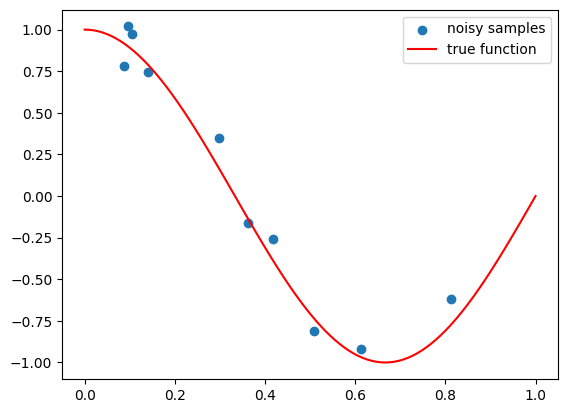

In [ ]:
plt.scatter(X, y, label='noisy samples')
plt.plot(X_test, true_function(X_test), c='r', label='true function')
plt.legend()

The following code will fit a polynomial regression, you need to fill the degree

In [ ]:
polynomial_features = PolynomialFeatures(degree=16,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X[:, np.newaxis], y)

# Plot of the degree-16 fit with without lambda regularization

Pipeline(steps=[('polynomial_features',
                 PolynomialFeatures(degree=16, include_bias=False)),
                ('linear_regression', LinearRegression())])

To plot the result, you can use the following code

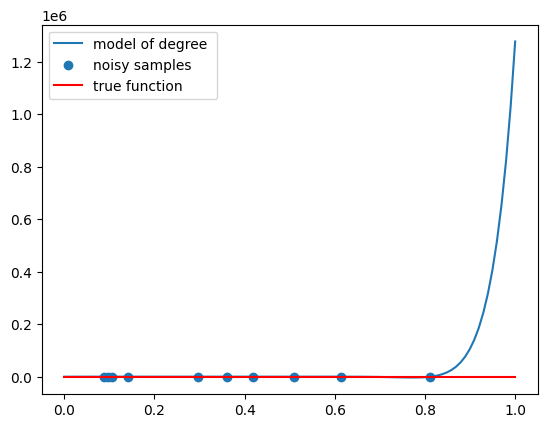

In [ ]:
plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="model of degree ")
plt.scatter(X, y, label='noisy samples')
plt.plot(X_test, true_function(X_test), c='r', label='true function')
plt.legend()

Next, we can investigate the effect of the regularization parameter $\lambda$ (function parameter `alpha`), For this, you can use the following code 

In [ ]:
polynomial_features = PolynomialFeatures(degree=16,
                                         include_bias=False)
ridge_regression = Ridge(alpha=1e-3)
pipeline_ridge = Pipeline([("polynomial_features", polynomial_features),
                     ("ridge_regression", ridge_regression)])
pipeline_ridge.fit(X[:, np.newaxis], y)

# Plot of the degree-16 fit with lambda=1e-3

Pipeline(steps=[('polynomial_features',
                 PolynomialFeatures(degree=16, include_bias=False)),
                ('ridge_regression', Ridge(alpha=0.001))])

For plotting you can reuse the following code

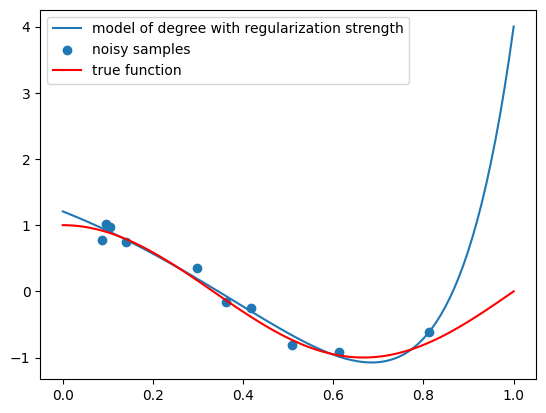

In [ ]:
plt.plot(X_test, pipeline_ridge.predict(X_test[:, np.newaxis]), label="model of degree with regularization strength")
plt.scatter(X, y, label='noisy samples')
plt.plot(X_test, true_function(X_test), c='r', label='true function')
plt.legend()

Now we are plotting for each degrees and lambdas.

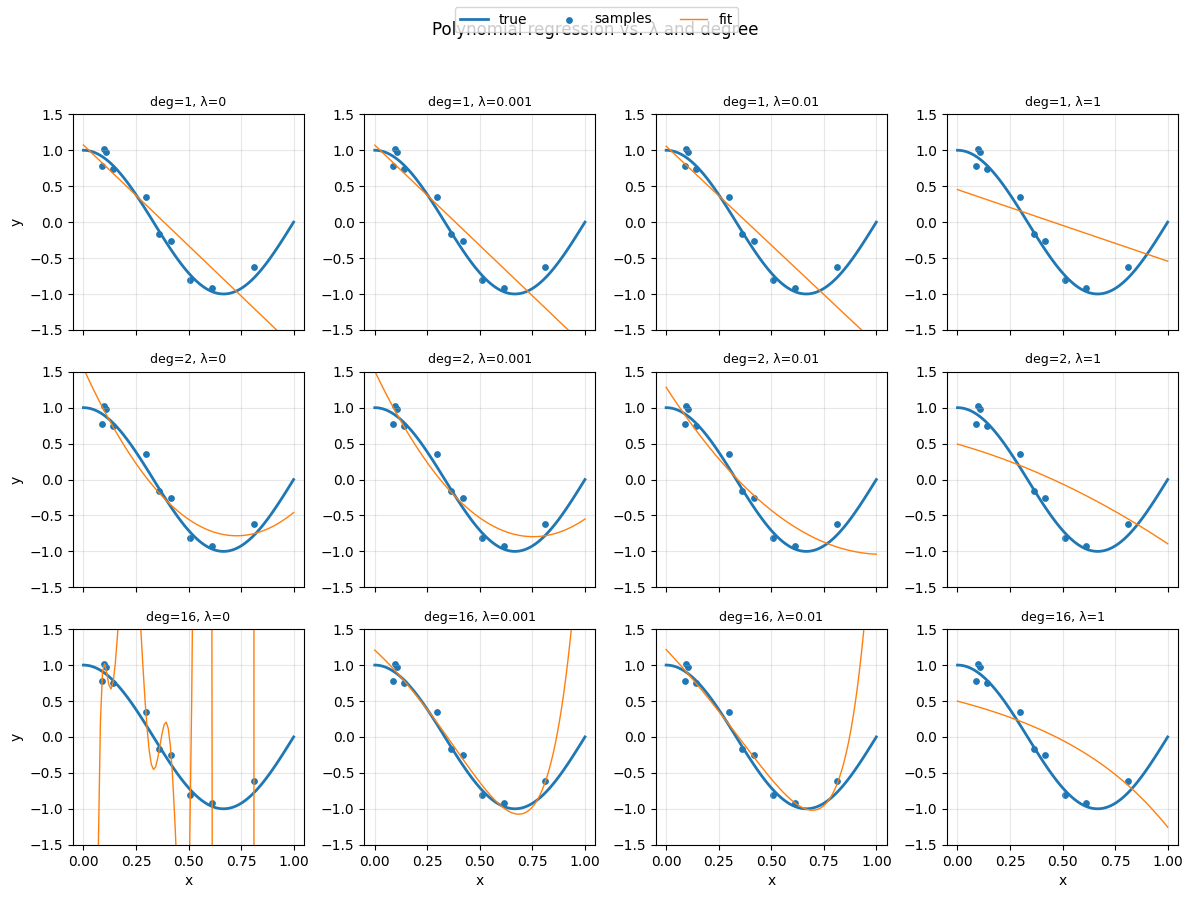

In [ ]:
lambdas = [0.0, 1e-3, 1e-2, 1.0]

fig, axes = plt.subplots(len(degrees), len(lambdas), figsize=(12, 9), sharex=True)  # no sharey
for i, d in enumerate(degrees):
    for j, lam in enumerate(lambdas):
        ax = axes[i, j]
        model = LinearRegression() if lam == 0.0 else Ridge(alpha=lam)
        pipe = Pipeline([
            ("poly", PolynomialFeatures(degree=d, include_bias=False)),
            # ("scale", StandardScaler()),  # optional stabilization
            ("reg", model),
        ])
        pipe.fit(X[:, None], y)
        yhat = pipe.predict(X_test[:, None])

        ax.plot(X_test, true_function(X_test), label='true', linewidth=2)
        ax.scatter(X, y, s=15, label='samples')
        ax.plot(X_test, yhat, label='fit', linewidth=1)

        ax.set_title(f"deg={d}, " + (r"λ=0" if lam == 0 else rf"λ={lam:g}"), fontsize=9)
        ax.set_ylim(-1.5, 1.5)  # <-- clamp here so every panel is readable
        if i == len(degrees)-1: ax.set_xlabel("x")
        if j == 0: ax.set_ylabel("y")
        ax.grid(True, alpha=0.3)

# single legend and title
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3)
fig.suptitle("Polynomial regression vs. λ and degree", y=0.98)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

#### Observations :
- For degree 1–2, the model’s capacity is too low and it underfits the cosine’s curvature regardless of λ; regularization has little visible effect because the model is already simple.

- With degree 16 and λ = 0, the model has very high capacity and overfits, producing large oscillations between noisy points.

- With degree 16 and small–moderate λ (10⁻³–10⁻²), ridge regularization shrinks the coefficients, the oscillations dampen, and the fit follows the main trend while ignoring noise—this is typically the best bias–variance trade-off.

- With degree 16 and large λ (≈1), the coefficients are penalized so strongly that high-order terms nearly vanish and the curve becomes over-smoothed, i.e., it underfits.

In short, degree sets potential flexibility, λ limits how much of that flexibility is used, and regularization penalizes large weights to encourage smoother, more generalizable fits; small λ can overfit at high degree, while large λ enforces simplicity but can underfit if too strong.

#### 2.16 What do you observe if you change the number of samples from the function?

With more samples:

- Overfitting becomes less severe (more data constrains the model better)
- High-degree polynomials become more stable
- Less regularization needed

With fewer samples:
- Easier to overfit
- High-degree polynomials oscillate wildly
- More regularization needed to prevent overfitting

#### 2.17 Why do we need a test set in machine learning?

We need a test set to:

1. Evaluate model performance on unseen data (generalization ability)
2. Detect overfitting (good training performance but poor test performance)
3. Get an unbiased estimate of model performance in production

The test set simulates real-world deployment where the model sees new data.

#### 2.18 If we need to optimize hyperparameters, do we use the test set to select the best hyperparameters? (1 point)

NO! We should NOT use the test set for hyperparameter selection. This would cause data leakage - the model indirectly "sees" the test data.
Instead, we should:
1. Use a validation set (or cross-validation on training data) for hyperparameter tuning
2. Reserve the test set ONLY for final evaluation after all decisions are made

This ensures the test set provides an unbiased estimate of real-world performance.